<a href="https://colab.research.google.com/github/lmcanavals/ml/blob/main/1301_FirstGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My First GAN

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(0)

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=28*28, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim*2),
            get_generator_block(hidden_dim*2, hidden_dim*4),
            get_generator_block(hidden_dim*4, hidden_dim*8),
            nn.Linear(hidden_dim*8, im_dim),
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.gen(noise)

    def get_gen(self):
        return self.gen

In [5]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [6]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )

In [7]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=28*28, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)

    def get_disc(self):
        return self.disc

## The data?

In [8]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cuda'
dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()),
                        batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [9]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [10]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

In [11]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True
gen_loss = False
error = False
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Failure runtime stuff")

        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

## Last product

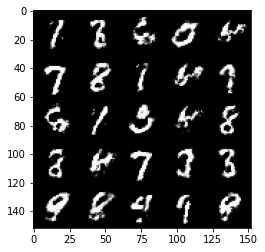

In [13]:
fake_noise = get_noise(cur_batch_size, z_dim, device=device)
fake = gen(fake_noise)
show_tensor_images(fake)

# Saving model

In [14]:
torch.save(disc.state_dict(), 'disc.pth')
torch.save(gen.state_dict(), 'gen.pth')

In [15]:
!ls -l

total 8132
-rw-r--r-- 1 root root 2267599 Nov  9 17:45 disc.pth
-rw-r--r-- 1 root root 6046987 Nov  9 17:45 gen.pth
drwxr-xr-x 3 root root    4096 Nov  9 15:26 MNIST
drwxr-xr-x 1 root root    4096 Nov  7 14:37 sample_data
